### Netflix Prize Dataset EDA

In this notebook, we perform exploratory data analysis on the Netflix Prize dataset, specifically among the top 10k users across our 9k selected movies.
We find that the most reviewed movies have more high ratings than low. Conversely, we find that the users with the most ratings have more low ratings than high.

In [1]:
import os
import json
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from collections import defaultdict


DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
IMDB_FOLDER_PATH = os.path.join(DATA_PATH, "imdb")
MIN_OCCURRENCES = 20


## Load Data

In [2]:
with open(os.path.join(DATA_PATH, 'top_netflix_users.json'), 'r') as f:
    top_netflix_users = json.load(f)

users_df = pd.DataFrame.from_dict(top_netflix_users, orient='index')
users_df.reset_index(inplace=True)
users_df.rename(columns={'index': 'user_id'}, inplace=True)
users_df['user_id'] = users_df['user_id'].astype(str)

with open(os.path.join(DATA_PATH, 'netflix_to_imdb.json'), 'r') as f:
    netflix_to_imdb = json.load(f)

netflix_movie_ids_with_imdb = set(netflix_to_imdb.keys())

title_basics_path = os.path.join(IMDB_FOLDER_PATH, 'title.basics.tsv.gz')
title_basics = pd.read_csv(title_basics_path, sep='\t', dtype=str, compression='gzip')

# title_basics = title_basics[['tconst', 'primaryTitle', 'titleType']]
title_basics = title_basics[title_basics['titleType'] == 'movie']

## Total Ratings Distribution Accross Top 10k Users

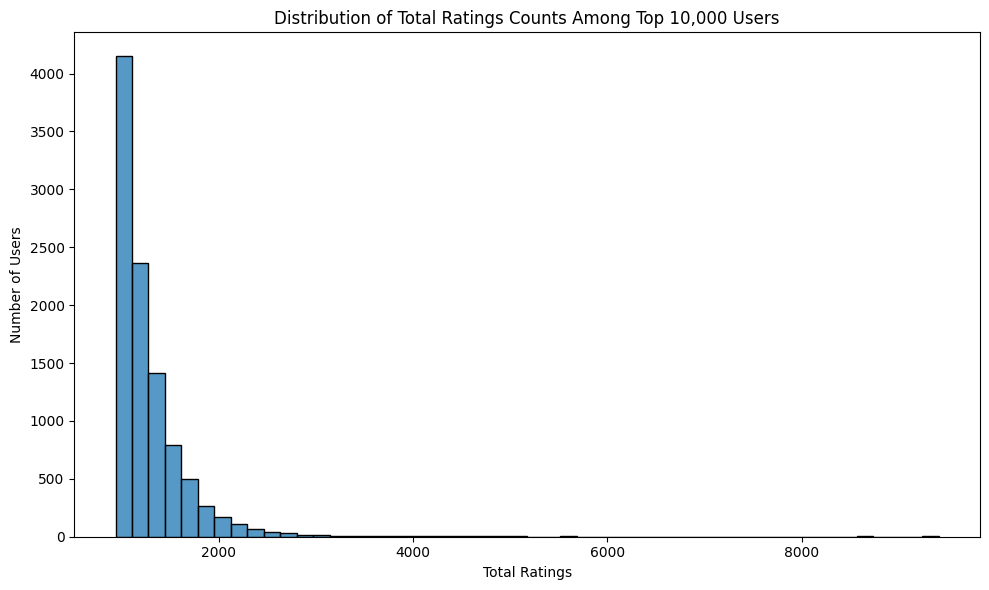

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(users_df['total_ratings'], bins=50, kde=False)
plt.title('Distribution of Total Ratings Counts Among Top 10,000 Users')
plt.xlabel('Total Ratings')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

## Top k Users With Most Ratings

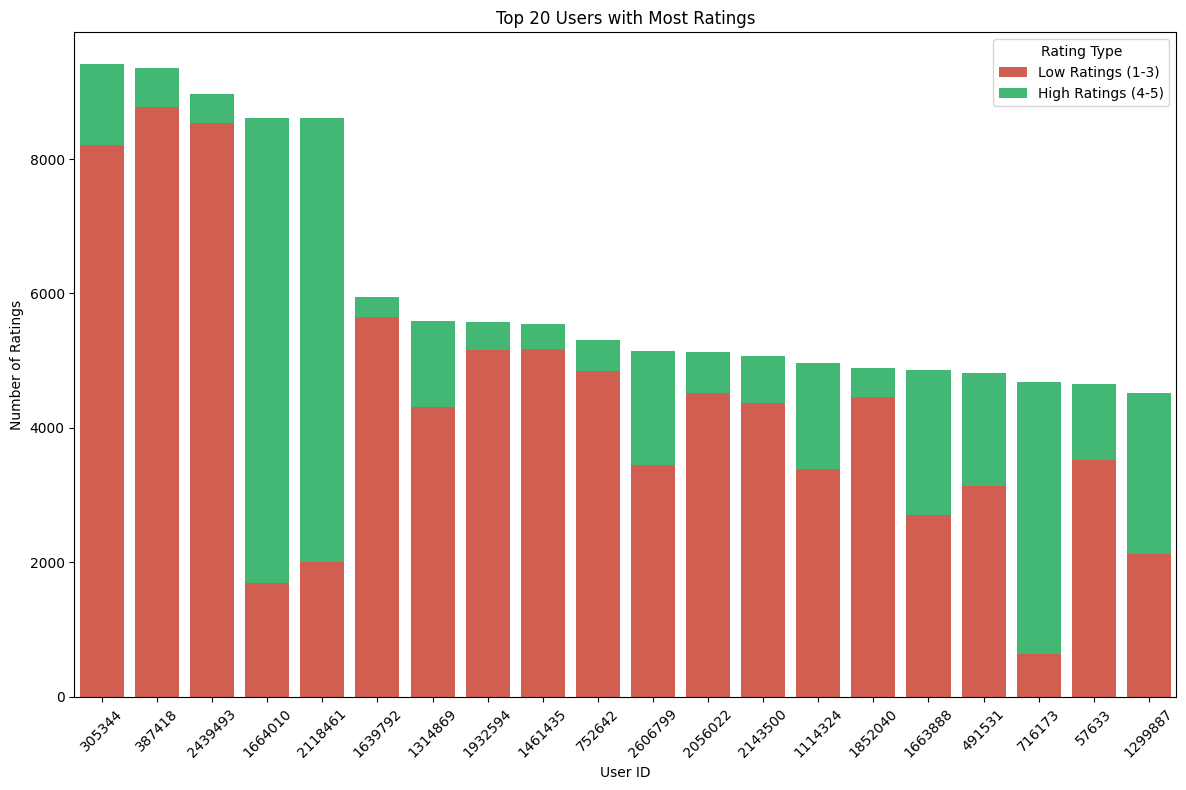

In [4]:
k = 20

# Get top k users by total ratings
top_k_users = users_df.nlargest(k, 'total_ratings')

# Create separate DataFrames for high and low ratings
high_ratings_df = pd.DataFrame({
    'user_id': top_k_users['user_id'],
    'count': top_k_users['high_ratings'],
    'rating_type': 'High Ratings (4-5)'
})

low_ratings_df = pd.DataFrame({
    'user_id': top_k_users['user_id'], 
    'count': top_k_users['low_ratings'],
    'rating_type': 'Low Ratings (1-3)'
})

# Combine the DataFrames
plot_df = pd.concat([high_ratings_df, low_ratings_df])

# Plot stacked barplot
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot low ratings first (bottom)
sns.barplot(x='user_id', y='count', data=low_ratings_df, 
            color='#e74c3c', label='Low Ratings (1-3)', ax=ax)

# Plot high ratings on top
sns.barplot(x='user_id', y='count', data=high_ratings_df,
            color='#2ecc71', label='High Ratings (4-5)', 
            bottom=low_ratings_df['count'], ax=ax)

plt.title(f'Top {k} Users with Most Ratings')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.legend(title='Rating Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Compile Ratings

In [5]:
movie_ratings = defaultdict(lambda: {'total_ratings': 0, 'high_ratings': 0, 'low_ratings': 0, 'user_ids': set()})

training_set_path = os.path.join(NETFLIX_FOLDER_PATH, 'training_set')
files = os.listdir(training_set_path)

# Process each file in the training set
for filename in files:
    filepath = os.path.join(training_set_path, filename)
    if filename.startswith('mv_') and filename.endswith('.txt'):
        movie_id = filename[3:-4].lstrip('0')
        if not movie_id:
            movie_id = '0'
        # Check if movie_id is in Netflix to IMDb mapping
        if movie_id in netflix_movie_ids_with_imdb:
            with open(filepath, 'r') as f:
                lines = f.readlines()
                for line in lines[1:]:  # Skip the first line containing the movie ID
                    user_id, rating, date = line.strip().split(',')
                    user_id = user_id.strip()
                    if user_id in top_netflix_users:
                        rating = int(rating)
                        movie_ratings[movie_id]['total_ratings'] += 1
                        movie_ratings[movie_id]['user_ids'].add(user_id)
                        if rating >= 4:
                            movie_ratings[movie_id]['high_ratings'] += 1
                        else:
                            movie_ratings[movie_id]['low_ratings'] += 1


Convert Movie Ratings to Dataframe

In [6]:
movies_df = pd.DataFrame.from_dict(movie_ratings, orient='index')
movies_df.reset_index(inplace=True)
movies_df.rename(columns={'index': 'movie_id'}, inplace=True)
movies_df['movie_id'] = movies_df['movie_id'].astype(str)

# Add IMDb IDs
movies_df['imdb_id'] = movies_df['movie_id'].map(netflix_to_imdb)

# Merge with title_basics to get movie names
movies_df = movies_df.merge(title_basics, left_on='imdb_id', right_on='tconst', how='left')
movies_df['primaryTitle'].fillna('Unknown Title', inplace=True)
movies_df.head()

/var/folders/kb/fzfpswzs5pvfz2g6vhp6r2dw0000gn/T/ipykernel_47363/668427385.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df['primaryTitle'].fillna('Unknown Title', inplace=True)


,movie_id,total_ratings,high_ratings,low_ratings,user_ids,imdb_id,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,373,25,4,21,"{572481, 845991, 1879665, 322009, 588285, 4207...",tt0179063,tt0179063,movie,Third World Cop,Third World Cop,0,1999,\N,98,"Action,Drama,Thriller"
1,10160,48,6,42,"{874505, 1672832, 563705, 2198070, 2136526, 13...",tt0086220,tt0086220,movie,Running Brave,Running Brave,0,1983,\N,106,"Biography,Drama,Sport"
2,9431,1634,259,1375,"{265257, 411290, 57633, 199435, 122503, 124750...",tt0208988,tt0208988,movie,Get Carter,Get Carter,0,2000,\N,102,"Action,Crime,Drama"
3,6702,7033,3661,3372,"{1281882, 984439, 2600419, 145916, 653682, 203...",tt0093886,tt0093886,movie,Roxanne,Roxanne,0,1987,\N,107,"Comedy,Romance"
4,4673,144,36,108,"{71594, 1272379, 442963, 2028737, 947651, 7994...",tt0091990,tt0091990,movie,Sorority House Massacre,Sorority House Massacre,0,1986,\N,74,Horror


## Top k Most Rated Movies (Total, High, Low)

In [7]:
k = 20

In [10]:
movies_df

,movie_id,total_ratings,high_ratings,low_ratings,user_ids,imdb_id,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,373,25,4,21,"{572481, 845991, 1879665, 322009, 588285, 4207...",tt0179063,tt0179063,movie,Third World Cop,Third World Cop,0,1999,\N,98,"Action,Drama,Thriller"
1,10160,48,6,42,"{874505, 1672832, 563705, 2198070, 2136526, 13...",tt0086220,tt0086220,movie,Running Brave,Running Brave,0,1983,\N,106,"Biography,Drama,Sport"
2,9431,1634,259,1375,"{265257, 411290, 57633, 199435, 122503, 124750...",tt0208988,tt0208988,movie,Get Carter,Get Carter,0,2000,\N,102,"Action,Crime,Drama"
3,6702,7033,3661,3372,"{1281882, 984439, 2600419, 145916, 653682, 203...",tt0093886,tt0093886,movie,Roxanne,Roxanne,0,1987,\N,107,"Comedy,Romance"
4,4673,144,36,108,"{71594, 1272379, 442963, 2028737, 947651, 7994...",tt0091990,tt0091990,movie,Sorority House Massacre,Sorority House Massacre,0,1986,\N,74,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9440,1074,864,539,325,"{469045, 1402224, 1844442, 863285, 332471, 117...",tt0038854,tt0038854,movie,The Postman Always Rings Twice,The Postman Always Rings Twice,0,1946,\N,113,"Crime,Drama,Film-Noir"
9441,16508,31,9,22,"{1453265, 1314869, 1181550, 203576, 188613, 66...",tt0140384,tt0140384,movie,Blind Beast,Môjû,0,1969,\N,86,"Drama,Horror"
9442,17616,49,17,32,"{1145956, 2012897, 71594, 2426167, 1951144, 21...",tt0033253,tt0033253,movie,The Westerner,The Westerner,0,1940,\N,100,"Drama,Western"
9443,10179,217,145,72,"{1563935, 2446249, 2227629, 1951144, 890675, 1...",tt0029546,tt0029546,movie,Shall We Dance,Shall We Dance,0,1937,\N,109,"Comedy,Musical,Romance"


In [19]:
def plot_top_k_movies(movies_df, k, sort_by, title, subtitle):
    """
    Plots a stacked bar chart for the top-k movies based on a specific column.

    Args:
    - movies_df (DataFrame): The movies DataFrame.
    - k (int): Number of top movies to select.
    - sort_by (str): Column to sort by (e.g., 'total_ratings', 'high_ratings', 'low_ratings').
    - title (str): Main title of the chart.
    - subtitle (str): Subtitle for additional context.
    
    Returns:
    - alt.Chart: The Altair chart object.
    """
    # Get top k movies by the specified column
    top_k_movies = movies_df.nlargest(k, sort_by)

    # Melt the DataFrame for stacked barplot
    top_k_movies_melted = top_k_movies.melt(
        id_vars=['primaryTitle', 'total_ratings'], 
        value_vars=['high_ratings', 'low_ratings'],
        var_name='rating_type', value_name='count'
    )

    # Create a shorter title if needed
    top_k_movies_melted['short_title'] = top_k_movies_melted['primaryTitle'].apply(
        lambda x: x[:30] + '...' if len(x) > 30 else x
    )

    # Sort by the selected column
    top_k_movies_melted['sort_key'] = top_k_movies_melted['primaryTitle'].map(
        dict(zip(top_k_movies['primaryTitle'], top_k_movies[sort_by]))
    )

    chart = alt.Chart(top_k_movies_melted).mark_bar().encode(
        x=alt.X('short_title:N',
                sort=alt.EncodingSortField(
                    field='sort_key',  # Sort by the selected column's values
                    order='descending'
                ),
                axis=alt.Axis(
                    title='Movie Title',
                    labels=True,
                    labelAngle=90
                )),
        y=alt.Y('count:Q', stack='zero'),
        color=alt.Color('rating_type:N', scale=alt.Scale(
            domain=['high_ratings', 'low_ratings'],
            range=['#2ecc71', '#e74c3c']
        )),
        tooltip=[
            alt.Tooltip('primaryTitle:N', title='Movie Title'),
            alt.Tooltip('rating_type:N', title='Rating Type'),
            alt.Tooltip('count:Q', title='Number of Ratings')
        ]
    ).properties(
        title=alt.TitleParams(
            title,
            subtitle=subtitle
        ),
        width=800,
        height=400
    )
    return chart


## Ratings Frequency Grouped by Movie Release Year

In [23]:
ratings_records = []

# Process each file in the training set
for filename in files:
    filepath = os.path.join(training_set_path, filename)
    if filename.startswith('mv_') and filename.endswith('.txt'):
        movie_id = filename[3:-4].lstrip('0')
        if not movie_id:
            movie_id = '0'
        # Check if movie_id is in Netflix to IMDb mapping
        if movie_id in netflix_movie_ids_with_imdb:
            imdb_id = netflix_to_imdb[movie_id]
            # Get the release year from title_basics
            release_year = title_basics.loc[title_basics['tconst'] == imdb_id, 'startYear']
            if not release_year.empty and release_year.values[0] != '\\N':
                release_year = int(release_year.values[0])
            else:
                release_year = None  # Handle missing or unknown years
            with open(filepath, 'r') as f:
                lines = f.readlines()
                for line in lines[1:]:  # Skip the first line containing the movie ID
                    user_id, rating, date = line.strip().split(',')
                    user_id = user_id.strip()
                    if user_id in top_netflix_users:
                        rating = int(rating)
                        rating_year = int(date.strip().split('-')[0])
                        high_or_low = 'High' if rating >= 4 else 'Low'
                        ratings_records.append({
                            'user_id': user_id,
                            'movie_id': movie_id,
                            'rating': rating,
                            'rating_year': rating_year,
                            'release_year': release_year,
                            'high_or_low': high_or_low
                        })


In [20]:
chart1 = plot_top_k_movies(movies_df, k=20, sort_by='total_ratings', title='Top 20 Most Rated Movies Among Top 10,000 Users', subtitle='High Ratings (4-5), Low Ratings (1-3)')
chart2 = plot_top_k_movies(movies_df, k=20, sort_by='high_ratings', title='Top 20 Most Highly Rated Movies Among Top 10,000 Users', subtitle='High Ratings (4-5), Low Ratings (1-3)')
chart3 = plot_top_k_movies(movies_df, k=20, sort_by='low_ratings', title='Top 20 Most Poorly Rated Movies Among Top 10,000 Users', subtitle='High Ratings (4-5), Low Ratings (1-3)')

# Display the charts
chart1.display()
chart2.display()
chart3.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [ ]:
ratings_df = pd.DataFrame(ratings_records)
ratings_df.head()

In [25]:
ratings_df = ratings_df.dropna(subset=['release_year'])
ratings_df['release_year'] = ratings_df['release_year'].astype(int)

In [ ]:
# Group by release_year and high_or_low
release_year_grouped = ratings_df.groupby(['release_year', 'high_or_low']).size().reset_index(name='count')
release_year_pivot = release_year_grouped.pivot(index='release_year', columns='high_or_low', values='count').fillna(0)
release_year_pivot['total_ratings'] = release_year_pivot.sum(axis=1)
release_year_pivot = release_year_pivot.reset_index()
release_year_pivot.head()

In [ ]:
# Sort by release_year
release_year_pivot.sort_values('release_year', inplace=True)

plt.figure(figsize=(14, 8))

# Stack 'Low' ratings on top of 'High' ratings
plt.bar(release_year_pivot['release_year'], release_year_pivot['High'], label='High Ratings (4-5)')
plt.bar(release_year_pivot['release_year'], release_year_pivot['Low'], bottom=release_year_pivot['High'], label='Low Ratings (1-3)')

plt.title('Ratings Frequency Grouped by Movie Release Year')
plt.xlabel('Movie Release Year')
plt.ylabel('Number of Ratings')
plt.legend()
plt.tight_layout()
plt.show()

### Plot Ratings Over Time

In [ ]:
# Group by rating_year and high_or_low
rating_year_grouped = ratings_df.groupby(['rating_year', 'high_or_low']).size().reset_index(name='count')
rating_year_pivot = rating_year_grouped.pivot(index='rating_year', columns='high_or_low', values='count').fillna(0)
rating_year_pivot['total_ratings'] = rating_year_pivot.sum(axis=1)
rating_year_pivot = rating_year_pivot.reset_index()
rating_year_pivot.head()

In [ ]:
# Sort by rating_year
rating_year_pivot.sort_values('rating_year', inplace=True)

plt.figure(figsize=(12, 8))

# Stack 'Low' ratings on top of 'High' ratings
plt.bar(rating_year_pivot['rating_year'], rating_year_pivot['High'], label='High Ratings (4-5)')
plt.bar(rating_year_pivot['rating_year'], rating_year_pivot['Low'], bottom=rating_year_pivot['High'], label='Low Ratings (1-3)')

plt.title('Ratings Frequency Grouped by Rating Submission Year')
plt.xlabel('Rating Submission Year')
plt.ylabel('Number of Ratings')
plt.legend()
plt.tight_layout()
plt.show()